Entraîner TrOCR sur un ensemble de données personnalisé de chèques pourrait pour réduire les erreurs.

In [1]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate


!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.8 MB/s eta

transformers : Il s'agit de la bibliothèque Hugging Face transformers qui nous donne accès à des centaines de modèles basés sur des transformateurs, y compris le modèle TrOCR.

sentencepiece : Il s'agit de la bibliothèque de tokenisation sentencepiece nécessaire pour convertir les mots en tokens et nombres. C'est également une partie de la famille Hugging Face.

jiwer : La bibliothèque jiwer nous donne accès à plusieurs métriques de reconnaissance vocale et de langage. Celles-ci incluent le WER (Word Error Rate) et le CER (Character Error Rate). Nous utiliserons la métrique CER pour évaluer le modèle pendant l'entraînement.

In [2]:
import os
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator,
    GenerationConfig
)

VisionEncoderDecoderModel : Nous avons besoin de cette classe pour définir différents modèles TrOCR.

TrOCRProcessor : TrOCR attend que le jeu de données suive un processus de normalisation particulier. Cette classe veillera à ce que les images soient correctement normalisées et traitées.

Seq2SeqTrainer : Ceci est nécessaire pour initialiser l'API Trainer.

Seq2SeqTrainingArguments : Pendant l'entraînement, l'API Trainer attend plusieurs arguments.

La classe Seq2SeqTrainingArguments initialise tous les arguments requis avant de les passer à l'API.

transforms : Le module de transformations Torchvision est nécessaire pour appliquer des augmentations de données aux images.


In [3]:
# the seed for reproducibility across different runs and define the computation device.

def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
%cd /content/drive/MyDrive/TrOCR

/content/drive/MyDrive/TrOCR


In [7]:
!ls fr

test.py  train	valid


In [8]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 16
    EPOCHS:        int = 100
    LEARNING_RATE: float = 0.0005

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = 'fr'

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-small-printed'

In [9]:
def is_image_file(filename):
    # Check if the file extension is a common image format
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))

# def visualize(dataset_path):
#     # Create subplots: 1 row for train images (15 images) and 1 row for valid images (10 images)
#     fig, axes = plt.subplots(2, 15, figsize=(25, 6))  # 2 rows, 15 columns (to leave space for all images)

#     # Get image files from both train and valid directories
#     all_images_train = [f for f in os.listdir(f"{dataset_path}/train") if is_image_file(f)]
#     all_images_valid = [f for f in os.listdir(f"{dataset_path}/valid") if is_image_file(f)]

#     # Ensure we have at least 15 images in the train set
#     num_images_train = min(15, len(all_images_train))
#     for i in range(num_images_train):
#         image_path = os.path.join(dataset_path, 'train', all_images_train[i])
#         try:
#             image = Image.open(image_path).convert('RGB')
#             axes[0, i].imshow(image)
#             axes[0, i].axis('off')
#             axes[0, i].set_title(f"Train: {all_images_train[i].split('.')[0]}")
#         except Exception as e:
#             print(f"Error loading train image {all_images_train[i]}: {e}")

#     # Ensure we have at least 10 images in the valid set
#     num_images_valid = min(10, len(all_images_valid))
#     for i in range(num_images_valid):
#         image_path = os.path.join(dataset_path, 'valid', all_images_valid[i])
#         try:
#             image = Image.open(image_path).convert('RGB')
#             axes[1, i].imshow(image)
#             axes[1, i].axis('off')
#             axes[1, i].set_title(f"Valid: {all_images_valid[i].split('.')[0]}")
#         except Exception as e:
#             print(f"Error loading valid image {all_images_valid[i]}: {e}")

#     # Hide unused subplots
#     for j in range(num_images_valid, 15):
#         axes[1, j].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Call the function with your dataset path
# visualize(DatasetConfig.DATA_ROOT)

In [10]:
# Load the CSV into a DataFrame
dataset_path=DatasetConfig.DATA_ROOT

train_df = pd.read_csv(f"{dataset_path}/train/train.csv")

# Rename columns
train_df.rename(columns={'file-name': 'file_name'}, inplace=True)



valid_df = pd.read_csv(f"{dataset_path}/valid/valid.csv")

# Rename columns
valid_df.rename(columns={'file-name': 'file_name'}, inplace=True)


print("Valid DataFrame:")
print(valid_df.head())


print("Train DataFrame:")
print(train_df.head())

Valid DataFrame:
    file_name                         text
0  000032.png                 Mille Dinars
1  000026.png   neuf-mille-sept-cent-trois
2  000027.png             quatre-vingt-six
3  000033.png               dix neuf dinar
4  000019.png  Six mille Deux cents Dinars
Train DataFrame:
    file_name                                    text
0  000032.png           Trente quatre mille cinq cent
1  000026.png             Six mille Deux cents Dinars
2  000027.png             Six mille Deux cents Dinars
3  000033.png                            vingt dinars
4  000019.png  Soixante Douze mille neuf cents Dinars


In [11]:
# def visualizeWithText(dataset_path, train_df, valid_df):
#     # Get image files from both train and valid directories
#     all_images_train = [f for f in os.listdir(f"{dataset_path}/train") if is_image_file(f)]
#     all_images_valid = [f for f in os.listdir(f"{dataset_path}/valid") if is_image_file(f)]

#     # Create dictionaries to map filenames to their texts
#     train_texts = dict(zip(train_df['file_name'], train_df['text']))
#     valid_texts = dict(zip(valid_df['file_name'], valid_df['text']))

#     # Number of images to show
#     num_train_images = len(all_images_train)
#     num_valid_images = len(all_images_valid)

#     # Calculate the grid size
#     num_cols_train = 5
#     num_cols_valid = 5
#     num_rows_train = (num_train_images + num_cols_train - 1) // num_cols_train
#     num_rows_valid = (num_valid_images + num_cols_valid - 1) // num_cols_valid

#     # Create subplots: enough rows and columns for all images
#     fig, axes = plt.subplots(num_rows_train + num_rows_valid, max(num_cols_train, num_cols_valid), figsize=(25, 6 * (num_rows_train + num_rows_valid)))

#     # Plot train images
#     for i in range(num_train_images):
#         row = i // num_cols_train
#         col = i % num_cols_train
#         image_path = os.path.join(dataset_path, 'train', all_images_train[i])
#         try:
#             image = Image.open(image_path).convert('RGB')
#             axes[row, col].imshow(image)
#             axes[row, col].axis('off')
#             axes[row, col].set_title(f"Train: {train_texts.get(all_images_train[i], '')}", fontsize=8)
#         except Exception as e:
#             print(f"Error loading train image {all_images_train[i]}: {e}")

#     # Hide unused subplots for train images
#     for i in range(num_train_images, num_rows_train * num_cols_train):
#         axes[i // num_cols_train, i % num_cols_train].axis('off')

#     # Plot valid images
#     for i in range(num_valid_images):
#         row = (num_rows_train + i // num_cols_valid)
#         col = i % num_cols_valid
#         image_path = os.path.join(dataset_path, 'valid', all_images_valid[i])
#         try:
#             image = Image.open(image_path).convert('RGB')
#             axes[row, col].imshow(image)
#             axes[row, col].axis('off')
#             axes[row, col].set_title(f"Valid: {valid_texts.get(all_images_valid[i], '')}", fontsize=8)
#         except Exception as e:
#             print(f"Error loading valid image {all_images_valid[i]}: {e}")

#     # Hide unused subplots for valid images
#     for i in range(num_valid_images, (num_rows_train + num_rows_valid) * max(num_cols_train, num_cols_valid)):
#         axes[i // max(num_cols_train, num_cols_valid), i % max(num_cols_train, num_cols_valid)].axis('off')

#     plt.tight_layout()
#     plt.show()

# visualizeWithText(dataset_path, train_df, valid_df)

In [13]:
# defining the augmentations
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
])

In [12]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length


    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        # The image file name.
        file_name = self.df['file_name'][idx]
        # The text (label).
        text = self.df['text'][idx]
        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(os.path.join(self.root_dir, file_name)).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(
            text,
            padding='max_length',
            max_length=self.max_target_length
        ).input_ids
        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

The __init__() method accepts the root directory path, the DataFrame, TrOCR processor, and the maximum label length as parameters.

The __getitem__() method first reads the label and image from the disk. It then passes the image through the transforms to apply the augmentations. The TrOCRProcessor returns the normalized pixel values in PyTorch tensor format. Next, the text labels are passed through the tokenizer. If a label is shorter than 128 characters, it is padded with -100 to a length of 128. If it is longer than 128 characters, then the characters are truncated.  Finally, it returns the pixel values and the labels as a dictionary.

In [14]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'train/'),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, 'valid/'),
    df=valid_df,
    processor=processor
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
# Charger le modèle pré-entraîné
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME)
model.to(device)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(

In [17]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id


model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [18]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.005
)

In [19]:
cer_metric = evaluate.load('cer')


def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions


    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)


    cer = cer_metric.compute(predictions=pred_str, references=label_str)


    return {"cer": cer}

In [20]:
# Définir les arguments d'entraînement
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    eval_strategy='epoch',
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_printed/',
    logging_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=5,
    report_to='tensorboard',
    num_train_epochs=TrainingConfig.EPOCHS
)

In [24]:
# Initialize trainer.
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_cer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=default_data_collator
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [25]:
res = trainer.train()

Epoch,Training Loss,Validation Loss,Cer
1,9.418100,5.253026,0.704939
2,4.235600,3.167100,0.645285
3,2.472400,1.772138,0.364336
4,1.486400,1.637375,0.416934
5,1.130700,1.195977,0.318794
6,0.738600,1.365769,0.218730
7,0.706100,1.046406,0.257216
8,0.544100,0.935386,0.303400
9,0.562500,1.185852,0.228993
10,0.591600,0.875227,0.148813


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (http

In [26]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
trained_model = VisionEncoderDecoderModel.from_pretrained('seq2seq_model_printed/checkpoint-'+str(res.global_step)).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.


    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [22]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.


    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

  0%|          | 0/61 [00:00<?, ?it/s]

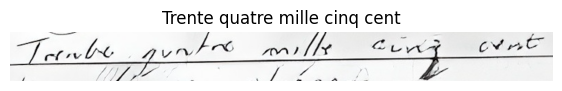

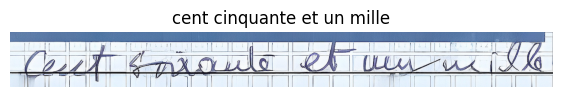

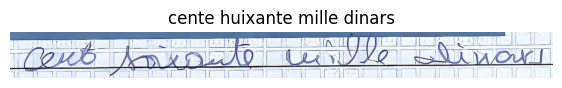

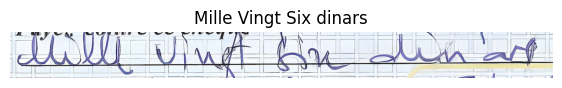

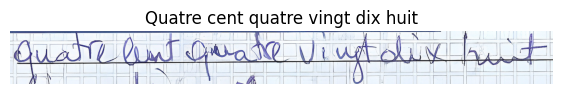

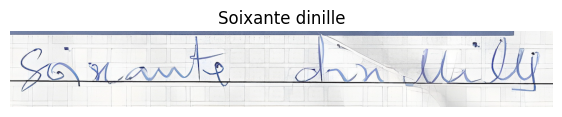

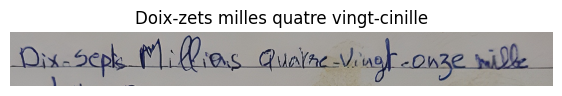

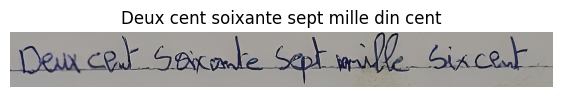

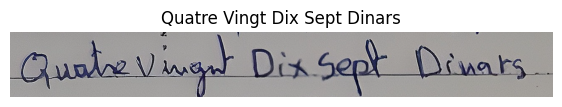

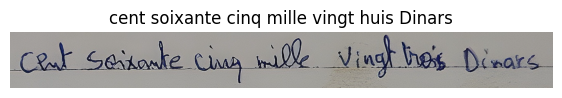

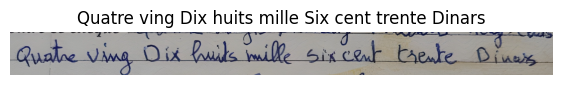

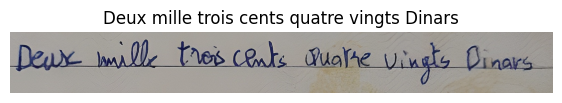

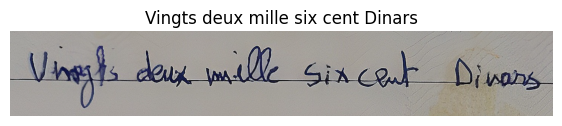

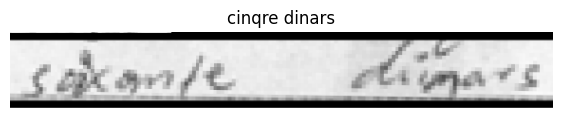

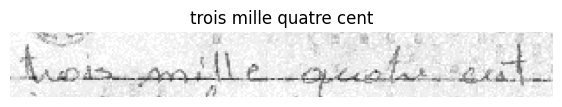

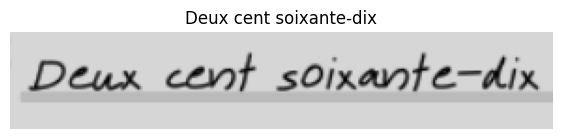

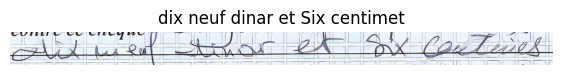

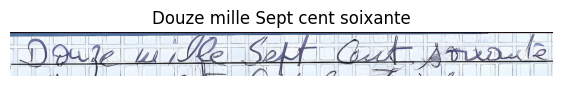

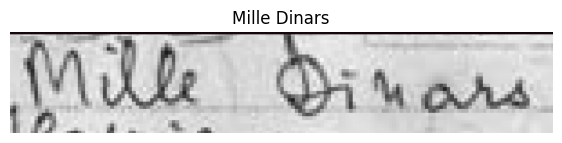

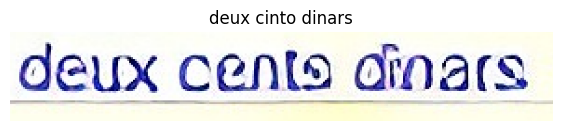

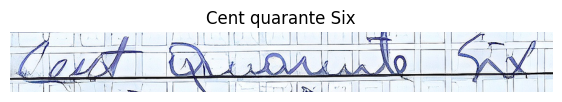

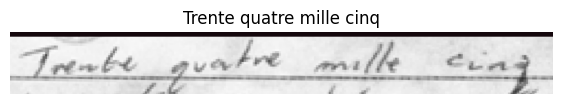

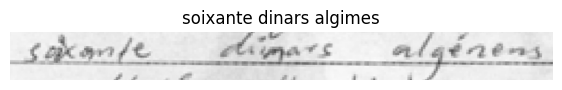

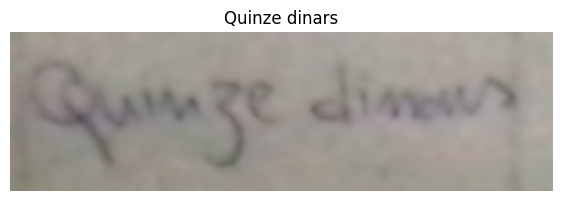

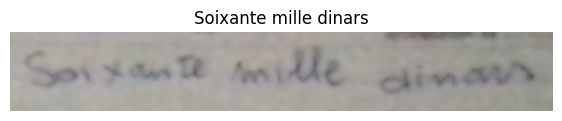

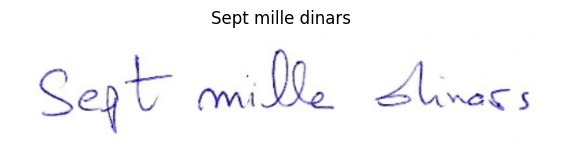

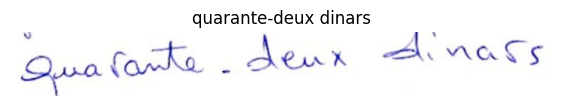

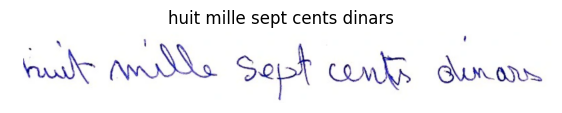

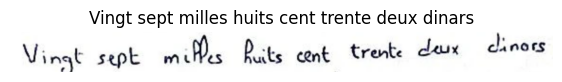

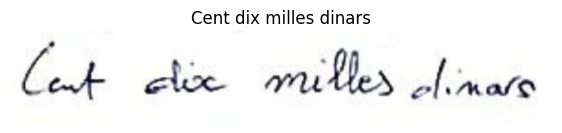

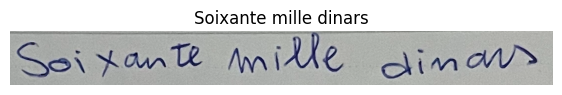

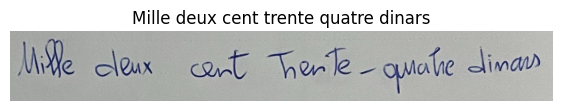

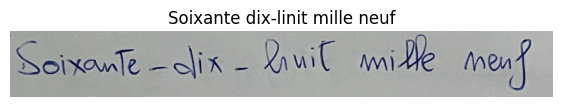

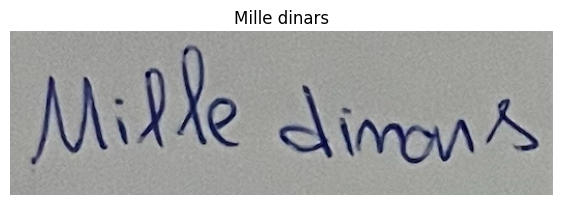

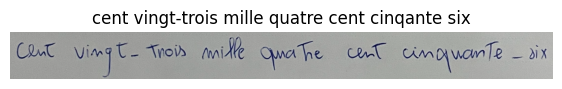

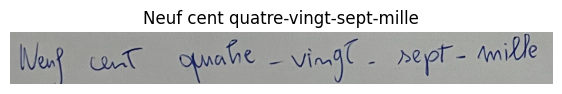

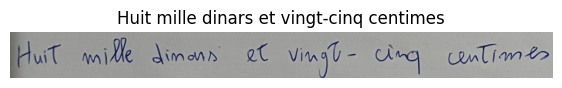

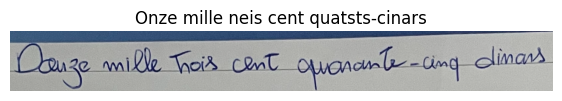

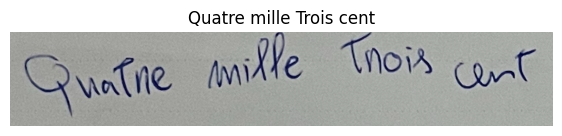

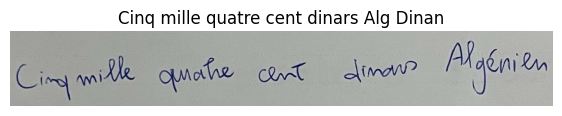

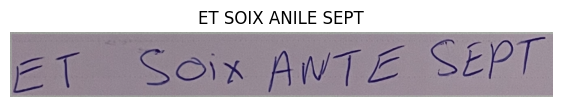

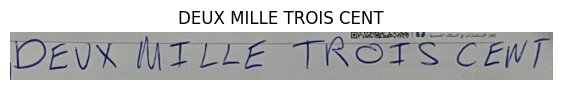

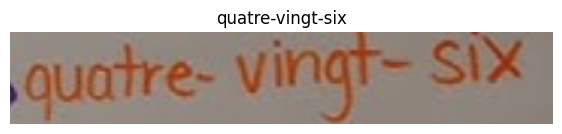

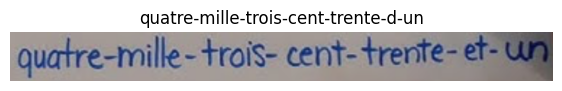

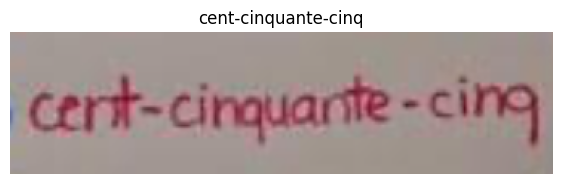

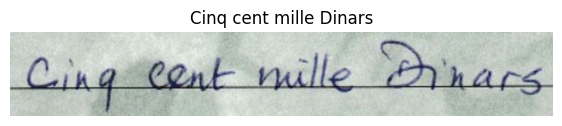

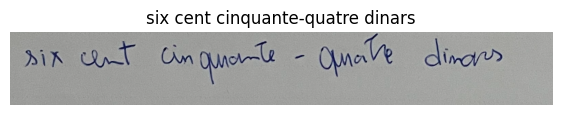

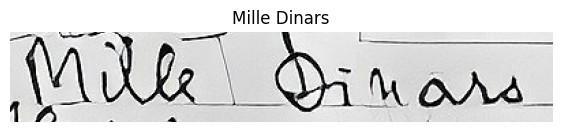

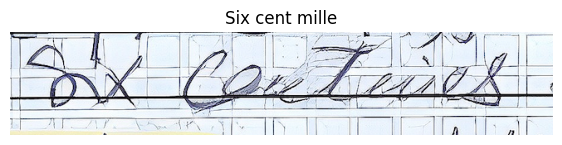

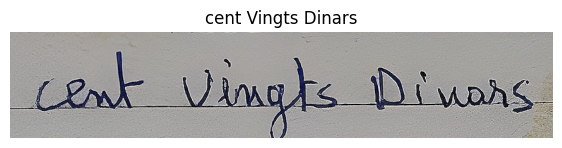

In [ ]:
def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'valid', '*'),
    num_samples=60
):
    image_paths = glob.glob(data_path)
    image_paths = [path for path in image_paths if is_image_file(path)]  # Filter out non-image files
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_and_show(image_path)
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()

eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, 'valid', '*'),
    num_samples=60
)
